In [13]:
from gluefactory.utils.experiments import load_experiment
from torchvision.transforms import Resize
from gluefactory.models.lines.deeplsd import DeepLSD
from gluefactory.models.extractors.superpoint_open import SuperPoint
from gluefactory.models.extractors.jpldd.joint_point_line_extractor import JointPointLineDetectorDescriptor
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import flow_vis
import os

In [14]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [34]:
model_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "model_name": "aliked-n16",
    "max_num_keypoints": 1000,  # setting for training, for eval: -1
    "pretrained": True,
    "timeit": True,  # override timeit: False from BaseModel
    "train_descriptors": {
        "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
        "device": None # device to house the lightweight ALIKED model
    }
}
#jpldd_model = load_experiment("../checkpoint_best.tar",model_conf)
jpldd_model = JointPointLineDetectorDescriptor({})

Load pretrained weights for aliked parts...
Load ALiked Lightweight model for descriptor training...


In [38]:
conf_lines = {
    "min_length": 15,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": False,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

sp_conf = {
    "max_num_keypoints": None,
    "nms_radius": 4,
    "detection_threshold": 0.005,
    "remove_borders": 4,
    "descriptor_dim": 256,
    "channels": [64, 64, 128, 128, 256],
    "dense_outputs": None,
    "weights": None,  # local path of pretrained weights
}

size = (800,800)


deeplsd_model = DeepLSD(conf_lines)
superpoint_model = SuperPoint(sp_conf)
deeplsd_model.eval()
resize_func = Resize(size)
image_path = "../data/mini_depth_100/00283.jpg"
img = cv2.resize(cv2.imread(image_path),size)
img_torch = numpy_image_to_torch(img)
img_torch = img_torch.unsqueeze(0)
with torch.no_grad():
    output_superpoint = superpoint_model({"image": img_torch})
    output_jpldd = jpldd_model({"image": img_torch})
    output_deeplsd = deeplsd_model.forward_ha({"image": img_torch})
distance_field_jpldd = torch.exp(-output_jpldd["deeplsd_line_distancefield"][0])*5
#distance_field_jpldd = output_jpldd["deeplsd_line_distancefield"][0]
angle_field_jpldd = output_jpldd["deeplsd_line_anglefield"][0]*torch.pi
distance_field_deeplsd = output_deeplsd["df"][0]
angle_field_deeplsd = output_deeplsd["line_level"][0]


tensor(2.8713)

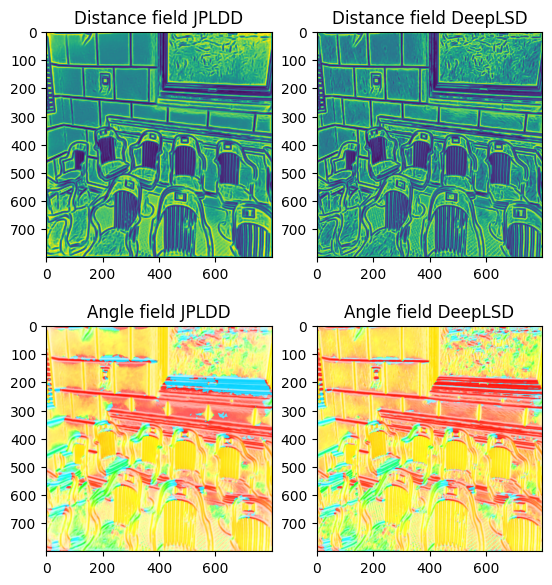

In [77]:
f, axarr = plt.subplots(2,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0][0].imshow(distance_field_jpldd)
axarr[0][0].set_title("Distance field JPLDD")
axarr[1][0].imshow(get_flow_vis(distance_field_jpldd,angle_field_jpldd))
axarr[1][0].set_title("Angle field JPLDD")
axarr[0][1].imshow(distance_field_deeplsd)
axarr[0][1].set_title("Distance field DeepLSD")
axarr[1][1].imshow(get_flow_vis(distance_field_deeplsd,angle_field_deeplsd))
axarr[1][1].set_title("Angle field DeepLSD")
f.set_figheight(7)

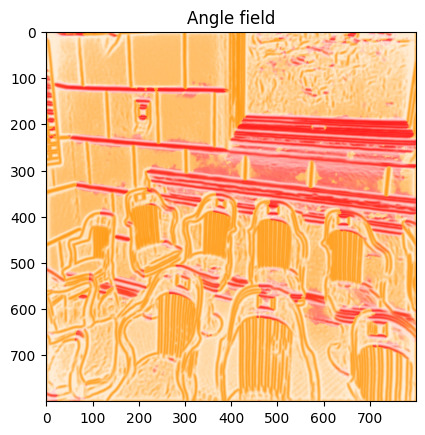

In [17]:
plt.title("Angle field")

plt.imshow(get_flow_vis(distance_field_jpldd,angle_field_jpldd))

In [33]:
test = angle_field_jpldd / torch.pi
test.min()

tensor(0.)

(array([[744.,  29.,  11., ...,   2.,   0.,   1.],
        [800.,   0.,   0., ...,   0.,   0.,   0.],
        [800.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [800.,   0.,   0., ...,   0.,   0.,   0.],
        [800.,   0.,   0., ...,   0.,   0.,   0.],
        [710.,  45.,  12., ...,   3.,   0.,   1.]]),
 array([1.14155782e-13, 9.96300578e-02, 1.99260116e-01, 2.98890173e-01,
        3.98520231e-01, 4.98150289e-01, 5.97780347e-01, 6.97410405e-01,
        7.97040462e-01, 8.96670520e-01, 9.96300578e-01]),
 <a list of 800 BarContainer objects>)

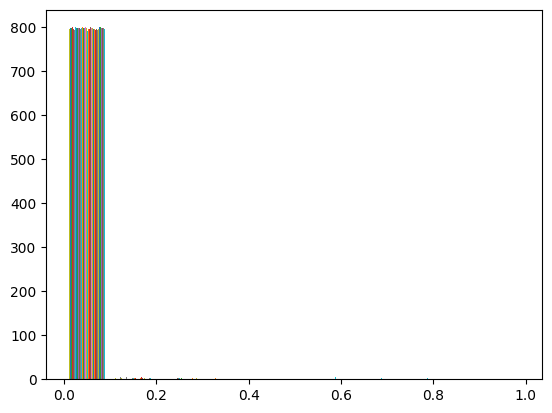

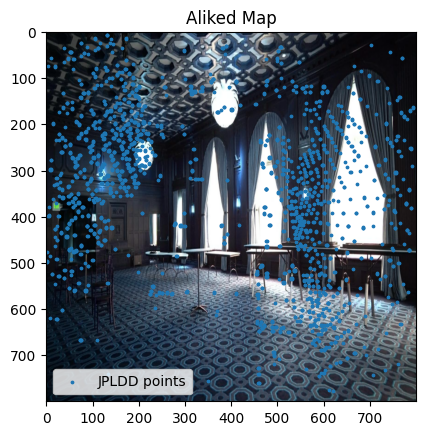

In [40]:
kp_junction_map = output_jpldd["keypoint_and_junction_score_map"][0]
superpoint_points = output_superpoint["keypoints"][0].t()
superpoint_map = output_superpoint["raw_scores"][0]
flat_indices = np.argpartition(kp_junction_map,-2000,axis=None)[-2000:]
mask = np.unravel_index(flat_indices,kp_junction_map.shape)
probs = kp_junction_map[mask]
pred = np.array(mask)
plt.imshow(img)
plt.title("Aliked Map")
#plt.scatter(superpoint_points[0],superpoint_points[1],s=3,label="Superpoint points")
plt.scatter(pred[0],pred[1],s=3,label="JPLDD points")
plt.legend()
plt.show()

In [43]:
sp_heatmap = output_superpoint["dense_descriptors"]

In [44]:
sp_heatmap.shape

torch.Size([1, 256, 100, 100])

In [ ]:
    # Open the HDF5 file and read the heatmap
    with h5py.File(filelist[i], 'r') as f:
        heatmap_data = np.array(f['superpoint_heatmap'])

    # Replace NaN values with 0
heatmap_data = np.nan_to_num(heatmap_data)

# normalise the heatmap by dividing by the maximum value
heatmap_data = heatmap_data / heatmap_data.max()

# Calculate the 10th percentile value
threshold = np.percentile(heatmap_data, 95)

# Find heatmap points above the 10th percentile
points = np.argwhere(heatmap_data > threshold)

# Read the grayscale image and resize it to match the heatmap
grayscale_image = cv2.imread(imagelist[i], cv2.IMREAD_GRAYSCALE)
grayscale_image = cv2.resize(grayscale_image, (800, 800))

heatmap_data_normalized = heatmap_data / np.max(heatmap_data)

# Get the existing Viridis colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Create a new colormap from the Viridis colors
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])  # RGBA color for white
newcolors[0, :] = white  # Set the lowest color to white
newcmp = ListedColormap(newcolors)

# print path of image
print(imagelist[i])

# Create a new figure for plotting
plt.figure(figsize=(18, 6))

# Plot the original heatmap
plt.subplot(1, 3, 1)
plt.imshow(heatmap_data_normalized, cmap=newcmp)
plt.title('Heatmap')

# Plot the original grayscale image
plt.subplot(1, 3, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Original Image')

# Plot the grayscale image with scatter plot of significant heatmap points
plt.subplot(1, 3, 3)
plt.imshow(grayscale_image, cmap='gray')
plt.scatter(points[:, 1], points[:, 0], c='red', s=0.01)  # s is the size of points
plt.title('Scatter on Image')

# Display the figure with the plots
plt.show()

{'keypoint_and_junction_score_map': tensor([[[1.2580e-08, 2.1121e-19, 2.1332e-19,  ..., 1.0620e-22,
           5.8866e-23, 2.1095e-16],
          [5.4713e-13, 9.5572e-29, 4.0118e-28,  ..., 4.3186e-33,
           2.0143e-33, 2.1799e-21],
          [1.0744e-14, 8.2550e-32, 5.7515e-31,  ..., 2.9376e-36,
           5.0213e-36, 7.5709e-23],
          ...,
          [1.6188e-15, 3.6705e-32, 3.6895e-32,  ..., 7.0363e-35,
           7.9172e-36, 3.4125e-23],
          [1.3073e-13, 5.6078e-28, 1.3300e-28,  ..., 7.3528e-31,
           7.7771e-32, 3.8826e-20],
          [3.3064e-08, 1.4957e-15, 9.9451e-16,  ..., 5.1592e-17,
           1.4471e-17, 6.3973e-10]]]),
 'deeplsd_line_anglefield': tensor([[[7.2136e-01, 7.0756e-01, 4.3792e-01,  ..., 8.6300e-07,
           1.9324e-05, 1.1977e-06],
          [1.9561e-02, 2.3981e-01, 2.2756e-01,  ..., 6.3455e-04,
           3.4066e-03, 6.1248e-10],
          [6.9770e-05, 1.7084e-05, 8.6330e-01,  ..., 8.0328e-01,
           2.1792e-09, 9.7894e-08],
          .